In [2]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy
from typing import Any, Sequence, Callable, NamedTuple, Optional, Tuple
PyTree = Any  # Type definition for PyTree, for readability
from copy import deepcopy
import pickle

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_15123/316186734.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial4_jax"

# Verifying the device that will be used throughout this notebook
print("Device:", jax.devices()[0])

Device: METAL:0


In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [5]:
import torch
import torch.utils.data as data
from torchvision.datasets import FashionMNIST
from torchvision import transforms


In [6]:
# Transformations applied on each image => bring them into a numpy array and normalize to mean 0 and std 1
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - 0.2861) / 0.3530
    return img

# We need to stack the batch elements as numpy arrays
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH,
                             train=True,
                             transform=image_to_numpy,
                             download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [50000, 10000],
                                                   generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH,
                        train=False,
                        transform=image_to_numpy,
                        download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
val_loader   = data.DataLoader(val_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
test_loader  = data.DataLoader(test_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)

In [7]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


In [8]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.008
Standard deviation: 1.009
Maximum: 2.022
Minimum: -0.810


In [9]:
# Network
class BaseNetwork(nn.Module):
    act_fn : Callable
    num_classes : int = 10
    hidden_sizes : Sequence = (512, 256, 256, 128)
    kernel_init : Callable = nn.linear.default_kernel_init

    @nn.compact
    def __call__(self, x, return_activations=False):
        x = x.reshape(x.shape[0], -1) # Reshape images to a flat vector
        # We collect all activations throughout the network for later visualizations
        # Remember that in jitted functions, unused tensors will anyways be removed.
        activations = []
        for hd in self.hidden_sizes:
            x = nn.Dense(hd,
                         kernel_init=self.kernel_init)(x)
            activations.append(x)
            x = self.act_fn(x)
            activations.append(x)
        x = nn.Dense(self.num_classes,
                     kernel_init=self.kernel_init)(x)
        activations.append(x)
        return x if not return_activations else (x, activations)

In [10]:
act_fn_by_name = {
    "tanh": nn.tanh,
    "relu": nn.relu,
    "identity": lambda x: x
}

In [11]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################

def visualize_weight_distribution(params, color="C0"):
    params, _ = jax.tree_util.tree_flatten(params)
    params = [p.reshape(-1) for p in params if len(p.shape) > 1]  # Remove biases
    params = jax.device_get(params)
    weights = {f'Layer {layer_idx*2}': p for layer_idx, p in enumerate(params)}

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False, collate_fn=numpy_collate)
exmp_imgs, exmp_labels = next(iter(small_loader))

def visualize_gradients(model, params, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    # Pass one batch through the network, and calculate the gradients for the weights
    def loss_func(p):
        logits = model.apply(p, exmp_imgs)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, exmp_labels).mean()
        return loss
    grads = jax.grad(loss_func)(params)
    grads = jax.device_get(grads)
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = jax.tree_util.tree_leaves(grads)
    grads = [g.reshape(-1) for g in grads if len(g.shape) > 1]
    grads = {f'Layer {layer_idx*2}': g for layer_idx, g in enumerate(grads)}

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, params, color="C0", print_variance=False):
    # Pass one batch through the network, and calculate the activations
    _, activations = model.apply(params, exmp_imgs, return_activations=True)
    activations = {f'Layer {layer_idx*2}': act.reshape(-1) for layer_idx, act in enumerate(activations[::2])}

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

In [12]:
def init_simple_model(kernel_init, act_fn=act_fn_by_name['identity']):
    model = BaseNetwork(act_fn=act_fn,
                        kernel_init=kernel_init)
    params = model.init(random.PRNGKey(42), exmp_imgs)
    return model, params

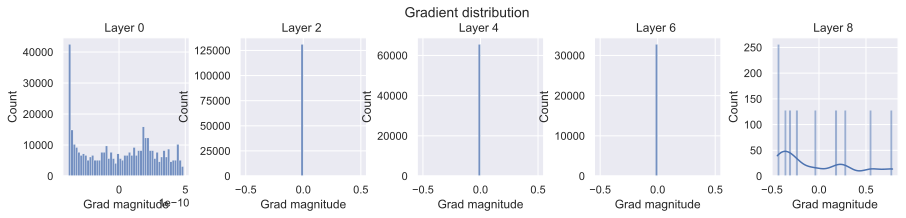

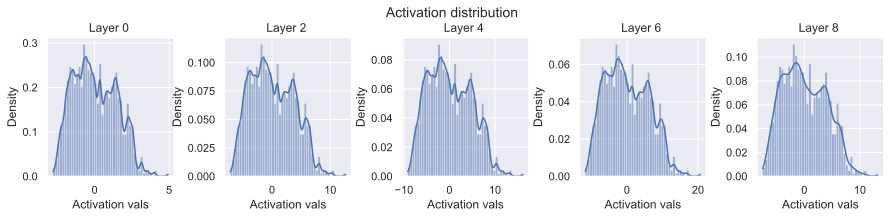

Layer 0 - Variance: 2.0582756996154785
Layer 2 - Variance: 13.489116668701172
Layer 4 - Variance: 22.100563049316406
Layer 6 - Variance: 36.20956039428711
Layer 8 - Variance: 14.831436157226562


In [13]:
# An initialization function in JAX takes as input a PRNG key,
# the shape of the parameter to create, and the data type
# (usually jnp.float32). We create this function based on the
# input parameter 'c' here, indicating the constant value
def get_const_init_func(c=0.0):
    return lambda key, shape, dtype: c*jnp.ones(shape, dtype=dtype)

model, params = init_simple_model(get_const_init_func(c=0.005))
visualize_gradients(model, params)
visualize_activations(model, params, print_variance=True)